In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd

In [2]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 9


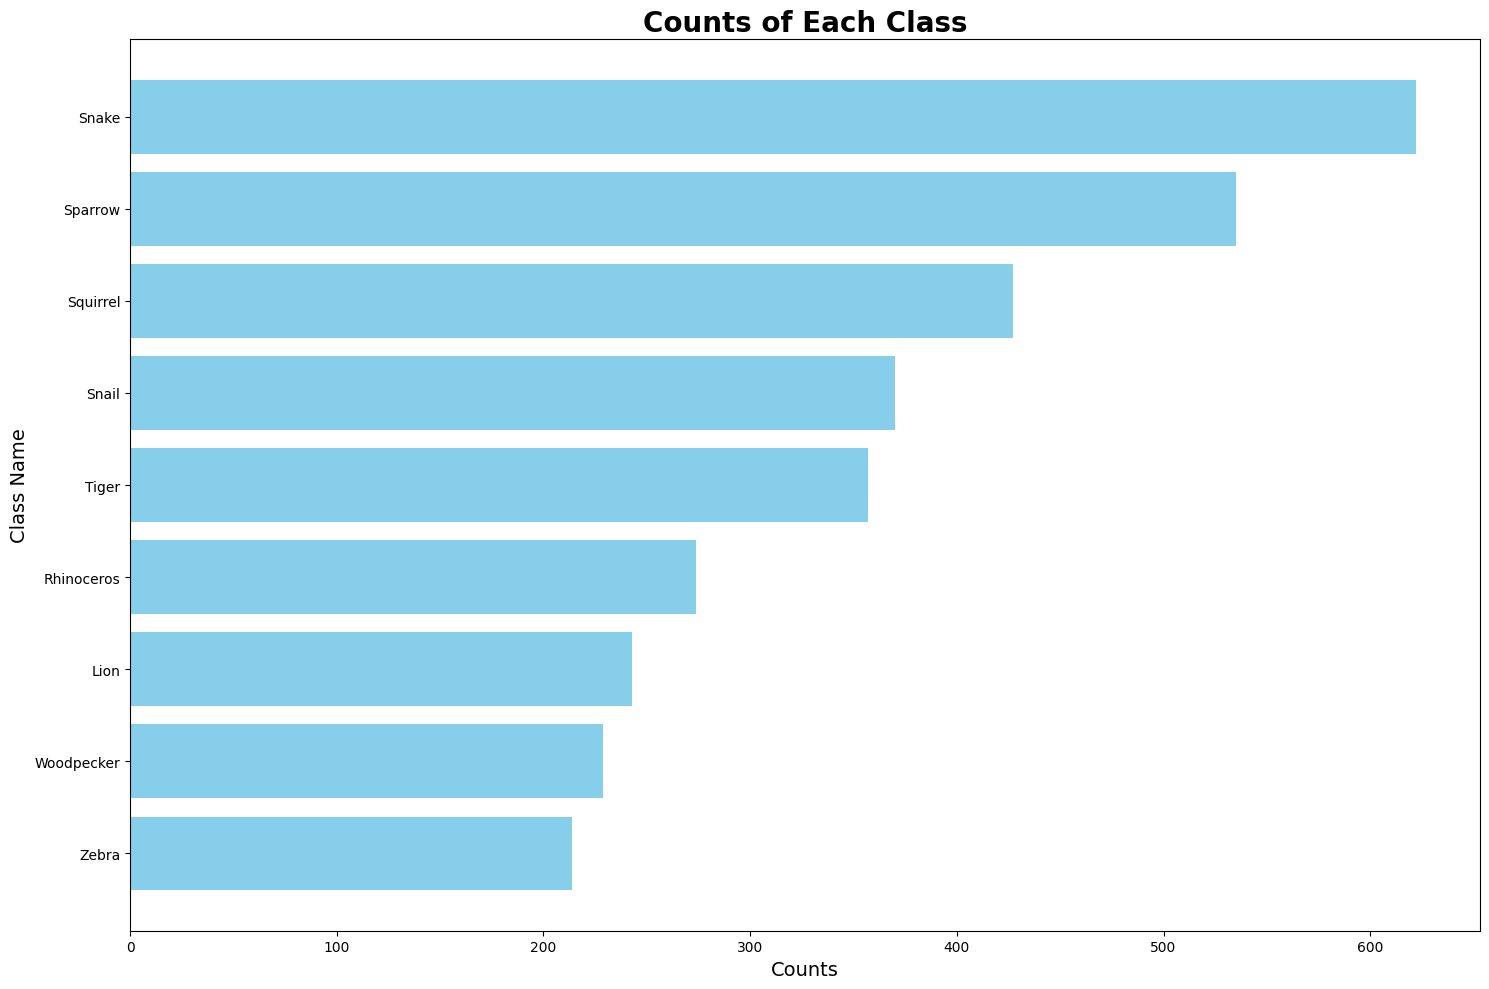

In [3]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

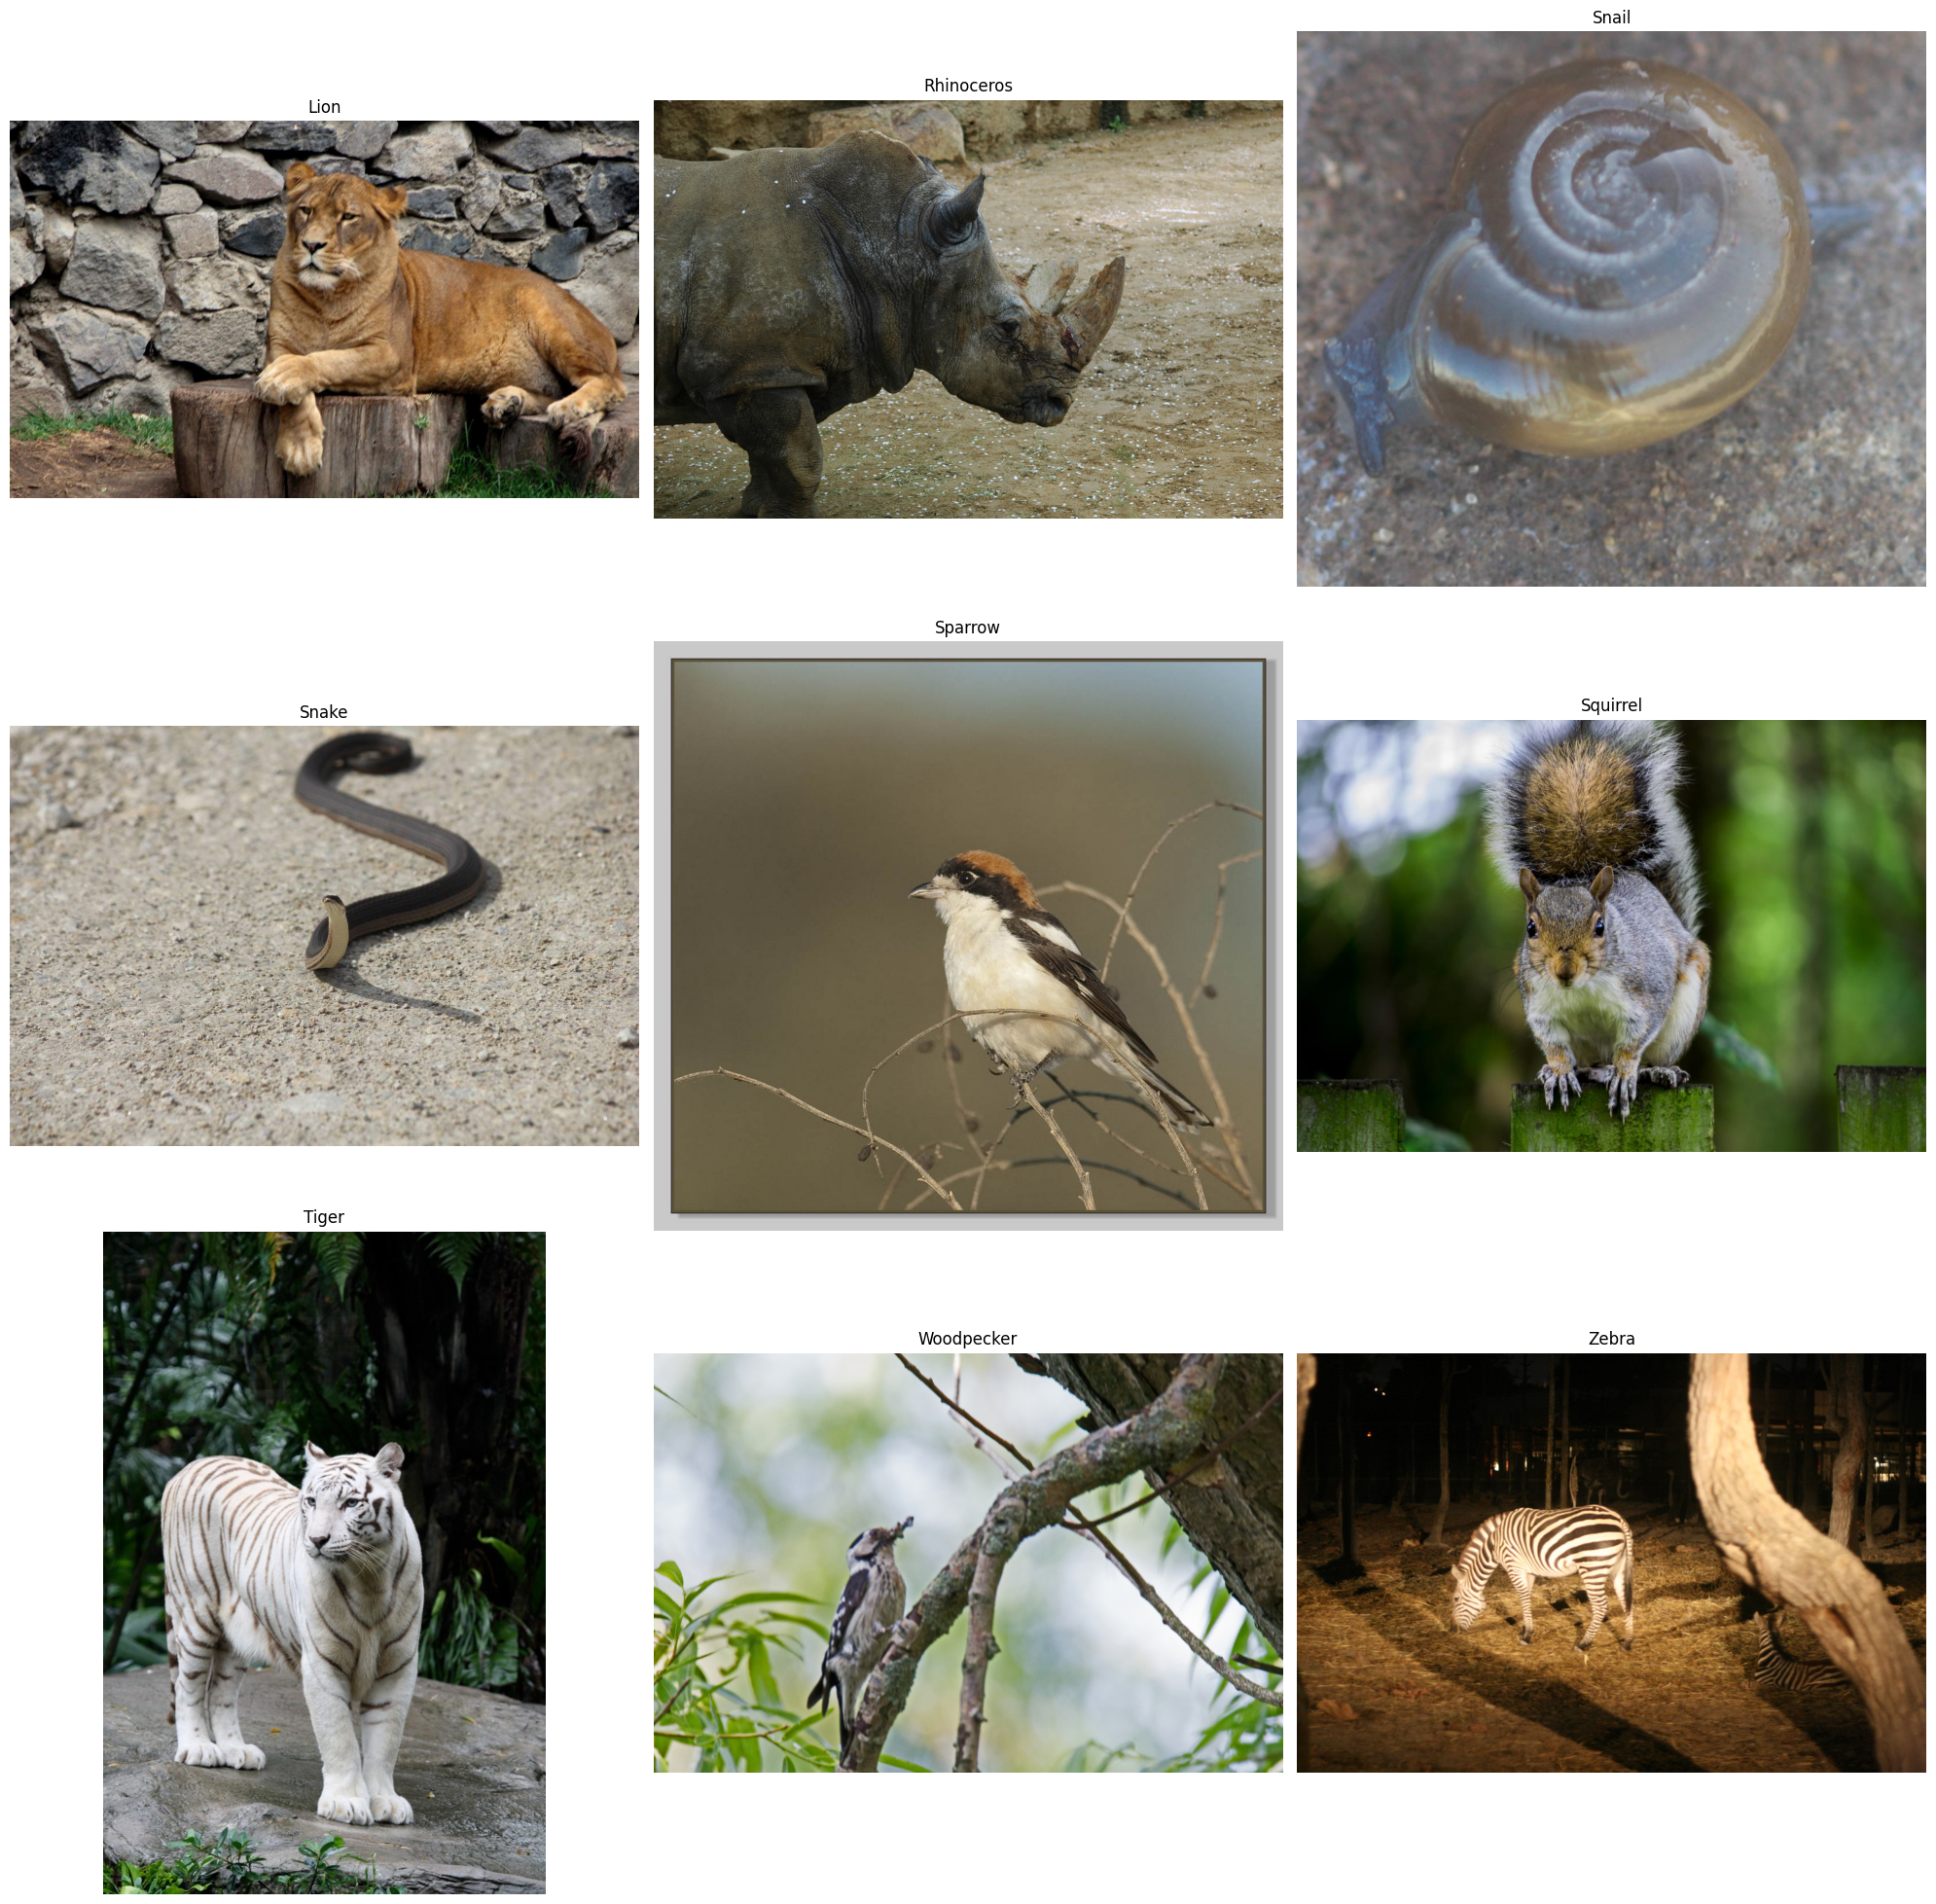

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    col = i // 3
    row = i % 3

    ax[col, row].imshow(img)
    ax[col, row].axis('off')
    ax[col, row].set_title(class_name)

plt.tight_layout()
plt.show()

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,    
)

# Shuffle dataset
train = train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

Found 3271 files belonging to 9 classes.


In [6]:
num_all_batches = len(list(train))
print("Number of all Batches: " + str(num_classes))

Number of all Batches: 9


In [7]:
num_train_batches = int(num_all_batches * 0.8)
num_valid_test_batches = int(num_all_batches - num_train_batches
)

train_ds = train.take(num_train_batches)

remain = train.skip(num_train_batches)

valid_ds = remain.take(num_valid_test_batches//2)
test_ds = remain.skip(num_valid_test_batches//2)


In [8]:
# Load VGG19 pretrained model with imagenet weights
pretrained_model = tf.keras.applications.VGG19(
    weights='imagenet', classes=80, input_shape=(224, 224, 3), include_top=False
)

# trocar para o VGG16 ???? (é o que está nos slides)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


In [9]:
# Show information of ResNet50V2 layers
pretrained_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Print all the layer's name in ResNet50V2
for layer in pretrained_model.layers :
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pretrained_model.trainable = True                # Whole model is trainable
set_trainable = False                            # Set a flag to False

for layer in pretrained_model.layers :           # A loop over model's layers
    if layer.name == 'block5_conv1' :            # Define target layer's name (with if condition)
        set_trainable = True                     # Change flag value to True
    if set_trainable :                           # A condition for True flag
        layer.trainable = True                   # Set layer trainablity to True
    else :                                       # else condition
        layer.trainable = False                  # For layers befor our target layer

In [12]:
# Add custom layers on top of the base model
model = tf.keras.models.Sequential()
model.add(pretrained_model)                               # At first add our pre-trained model
model.add(tf.keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(tf.keras.layers.GlobalAveragePooling2D())          # Apply GlobalAveragePooling2D
model.add(tf.keras.layers.Flatten())                         # Convert the output to 1D arraay
model.add(tf.keras.layers.Dense(1024, activation='relu'))    # Add a Dense layer with 1024 neuron with activation='relu'
model.add(tf.keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(tf.keras.layers.Dense(512, activation='relu'))     # Add a Dense layer with 512 neuron with activation='relu'
model.add(tf.keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(tf.keras.layers.Dense(80, activation='softmax'))   # Add a Dense layer with number fo classes neuron as output with activation='softmax'

In [13]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=100,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 9), output.shape=(None, 80)

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

In [ ]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].set_xticks(np.arange(0, len(x), 2))
ax[2].legend()

plt.show()

In [ ]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
best_model = tf.keras.models.load_model('MyModel.keras')

In [ ]:
# Evaluate model by model.evaluate()
loss, accuracy = best_model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')